In [1]:
from ABM_MeanField_Cells.model import GentModel
from ABM_MeanField_Cells.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from utils_gent_measure import *
import networkx as nx
import matplotlib.gridspec as gridspec
import math
np.set_printoptions(linewidth=400)
%matplotlib inline

import os
#set a nice seaborn style

pd.options.mode.chained_assignment = None

sns.set()
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid")
sns.set_context("talk")

#ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


width = height = 7


import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=width*height)


/home/gmauro/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


'out/plots/centre_segr'

In [3]:
%%script false --no-raise-error
p_g_list = [0.01, 0.05, 0.1, 0.15]
h_list = [20]
delta_list = [10, 15, 20]  # List of delta values
num_rep = 150

# Create a nested defaultdict to store results
num_peaks_chi_hat = defaultdict(lambda: defaultdict(int))
num_peaks_gamma = defaultdict(lambda: defaultdict(int))

# Iterate through all combinations of pg, h, delta, and rep
for p_g in tqdm(p_g_list):
    p_g_str = f"pg_{p_g}_"
    for h in h_list:
        h_str = f"h_{h}_"
        for delta in delta_list:
            delta_str = f"delta_{delta}_"
            for rep in range(num_rep):
                rep_str = f"rep_{rep}_"

                # Construct filename for chi_hat
                chi_hat_filename = f"{p_g_str}{h_str}{rep_str}{delta_str}results_chi_hat.csv"
                gamma_filename = f"{p_g_str}{h_str}{rep_str}{delta_str}results_net_avg_prod.csv"

                # Process the chi_hat file
                chi_hat_file_path = os.path.join(intermediate_dir, chi_hat_filename)
                if os.path.exists(chi_hat_file_path):
                    df_chi_hat = pd.read_csv(chi_hat_file_path, index_col=0)
                    for cell in df_chi_hat.columns:
                        peaks_chi_hat = find_shifts(df_chi_hat[cell].reset_index(drop=True))
                        num_peaks_chi_hat[p_g][len(peaks_chi_hat)] += 1

                gamma_file_path = os.path.join(intermediate_dir, gamma_filename)
                if os.path.exists(gamma_file_path):
                    df_gamma = pd.read_csv(gamma_file_path, index_col=0)
                    df_gamma.fillna(0, inplace=True)
                    for cell in df_gamma.columns:
                        peaks_gamma = find_peaks_custom(df_gamma[cell].reset_index(drop=True))
                        num_peaks_gamma[p_g][len(peaks_gamma)] += 1




percentages_chi_hat = {}
percentages_gamma = {}

for p_g in p_g_list:
    total_counts_chi_hat = sum(num_peaks_chi_hat[p_g].values())
    zero_one_peak_ratio_chi_hat = (num_peaks_chi_hat[p_g][0] + num_peaks_chi_hat[p_g][1]) / total_counts_chi_hat if total_counts_chi_hat > 0 else 0
    percentages_chi_hat[p_g] = zero_one_peak_ratio_chi_hat * 100  # Convert to percentage

    total_counts_gamma = sum(num_peaks_gamma[p_g].values())
    zero_one_peak_ratio_gamma = (num_peaks_gamma[p_g][0] + num_peaks_gamma[p_g][1]) / total_counts_gamma if total_counts_gamma > 0 else 0
    percentages_gamma[p_g] = zero_one_peak_ratio_gamma * 100  # Convert to percentage

# Create a DataFrame
df = pd.DataFrame({
    'Chi-hat': percentages_chi_hat,
    'Gamma': percentages_gamma
}).T  # Transpose the DataFrame to have measures on rows

# Sort the columns (p_g values)
df = df.sort_index(axis=1)

# Display the DataFrame
print(df)

# Create a LaTeX table
latex_table = df.to_latex(float_format="%.2f")

# Improve LaTeX table formatting
latex_table = "\\begin{table}[h]\n\\centering\n\\renewcommand{\\arraystretch}{1.2}\n" + latex_table
latex_table = latex_table.replace('\\begin{tabular}', '\\begin{tabular}{l|rrrrr}')
latex_table = latex_table.replace('\\toprule', '\\hline')
latex_table = latex_table.replace('\\midrule', '\\hline')
latex_table = latex_table.replace('\\bottomrule', '\\hline')
latex_table = latex_table.replace('Chi-hat', '$\mathcal{G}_{bin}$')
latex_table = latex_table.replace('Gamma', '$\mathcal{G}_{net}$')
latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\n\\caption{Percentage of cases with 0-1 peaks for different $p_g$ values}\n\\label{tab:peak_percentages}')
latex_table += '\\end{table}'

print("\nLaTeX Table:")
print(latex_table)


In [3]:
# Function to create chi_hat_bin from chi_hat
def create_chi_hat_bin(chi_hat_series):
    result = np.zeros_like(chi_hat_series)
    changes = np.diff(chi_hat_series)
    shift_indices = np.where(changes == 1)[0] + 1
    result[shift_indices] = 1
    return result

# Function to create gamma_bin from gamma
def create_gamma_bin(gamma_series, find_peaks_custom):
    result = np.zeros_like(gamma_series)
    peak_indices = find_peaks_custom(gamma_series)
    
    # Ensure indices are integers and within bounds
    peak_indices = np.round(peak_indices).astype(int)
    peak_indices = peak_indices[(peak_indices >= 0) & (peak_indices < len(result))]
    
    result[peak_indices] = 1
    return result

# Function to create shuffled versions of chi_hat_bin
def create_shuffled_versions(chi_hat_bin, num_shuffles=50):
    return [np.random.permutation(chi_hat_bin) for _ in range(num_shuffles)]
# Function to calculate cross-correlation between two binary series
def calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag=10):
    correlation_values = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            segment1 = chi_hat_bin[-lag:]
            segment2 = gamma_bin[:lag]
        elif lag > 0:
            segment1 = chi_hat_bin[:-lag]
            segment2 = gamma_bin[lag:]
        else:
            segment1 = chi_hat_bin
            segment2 = gamma_bin

        # Check for meaningful correlation only if both segments have variation
        if np.any(segment1) and np.any(segment2):
            corr = np.corrcoef(segment1, segment2)[0, 1]
        else:
            corr = 0  # No meaningful correlation if both segments are flat or have no overlap

        correlation_values.append(corr)
    
    return lags, correlation_values




def calculate_shuffled_correlations_bidirectional(gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=10):
    shuffled_correlations = []

    # Precompute all shuffled versions of chi_hat_bin and gamma_bin
    shuffled_chi_hat_bins = [np.random.permutation(chi_hat_bin) for _ in range(num_shuffles)]
    shuffled_gamma_bins = [np.random.permutation(gamma_bin) for _ in range(num_shuffles)]

    for shuffle_idx in range(num_shuffles):
        # For each shuffle, we will calculate the cross-correlation using the pre-defined function
        # Negative lags: Shuffle chi_hat_bin, keep gamma_bin fixed
        _, corr_neg = calculate_cross_correlation(shuffled_chi_hat_bins[shuffle_idx], gamma_bin, max_lag)
        
        # Positive lags: Shuffle gamma_bin, keep chi_hat_bin fixed
        _, corr_pos = calculate_cross_correlation(chi_hat_bin, shuffled_gamma_bins[shuffle_idx], max_lag)
        
        # Combine correlations into a single array
        combined_corr = list(corr_neg[:max_lag + 1]) + list(corr_pos[max_lag + 1:])
        shuffled_correlations.append(combined_corr)
    
    # Convert to numpy array for easier percentile calculations
    shuffled_correlations = np.array(shuffled_correlations)
    
    # Calculate mean, 5th, and 95th percentiles
    mean_shuffled_corr = np.mean(shuffled_correlations, axis=0)
    lower_bound = np.percentile(shuffled_correlations, 5, axis=0)
    upper_bound = np.percentile(shuffled_correlations, 95, axis=0)
    
    return mean_shuffled_corr, lower_bound, upper_bound



In [4]:
# Fixed parameters
h = 20
delta = 15
max_lag = delta
num_rep = 150

# Values of p_g to iterate over
pg_values = [0.01, 0.05, 0.1, 0.15]

# Folder containing the data files (replace with actual path)
intermediate_folder = intermediate_dir  # Update this path to your actual data folder

In [ ]:
%%script false --no-raise-error
# Store correlation values for all p_g values
all_correlations = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []


# Iterate over each p_g value
for p_g in pg_values:
    all_lag_correlations = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    # File paths for the fixed parameters and repetitions
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]
    
    # Process each file pair and calculate correlations
    for chi_hat_file, gamma_file in tqdm(zip(chi_hat_files, gamma_files), total=len(chi_hat_files)):
        if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
            chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
            gamma_df = pd.read_csv(gamma_file, index_col=0)
            
            # Fill initial NaNs with zeros
            chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
            gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})
            
            for column in chi_hat_df.columns:
                if column in gamma_df.columns:
                    chi_hat_series = chi_hat_df[column].values
                    gamma_series = gamma_df[column].values
                    
                    # Create binary series
                    chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                    gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)
                    
                    # Calculate cross-correlation for the binary series
                    lags, correlation_values = calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag)
                    all_lag_correlations.append(correlation_values)
                    
                    # Calculate cross-correlation for shuffled binary series
                    mean_shuffled_corr, lower_bound, upper_bound = calculate_shuffled_correlations_bidirectional(gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag)
                    
                    # Append shuffled correlation statistics
                    all_lag_shuffled_means.append(mean_shuffled_corr)
                    all_lag_shuffled_lowers.append(lower_bound)
                    all_lag_shuffled_uppers.append(upper_bound)

    # Average correlation values across all repetitions and columns for this p_g
    if all_lag_correlations:
        avg_correlation = np.mean(all_lag_correlations, axis=0)
        all_correlations.append(avg_correlation)
        
    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)
        
        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)



In [8]:

from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed



# Function to process a single file pair and return the correlation results
def process_file_pair(chi_hat_file, gamma_file, h, max_lag):
    # Initialize empty results
    result = None
    shuffled_result = None
    lags = None  # Initialize lags variable
    
    if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
        chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
        gamma_df = pd.read_csv(gamma_file, index_col=0)

        # Fill initial NaNs with zeros
        chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
        gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

        all_lag_correlations = []
        all_lag_shuffled_means = []
        all_lag_shuffled_lowers = []
        all_lag_shuffled_uppers = []

        for column in chi_hat_df.columns:
            if column in gamma_df.columns:
                chi_hat_series = chi_hat_df[column].values
                gamma_series = gamma_df[column].values

                # Create binary series
                chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)

                # Calculate cross-correlation for the binary series
                lags, correlation_values = calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag)
                all_lag_correlations.append(correlation_values)

                # Calculate cross-correlation for shuffled binary series
                mean_shuffled_corr, lower_bound, upper_bound = calculate_shuffled_correlations_bidirectional(
                    gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag)

                # Append shuffled correlation statistics
                all_lag_shuffled_means.append(mean_shuffled_corr)
                all_lag_shuffled_lowers.append(lower_bound)
                all_lag_shuffled_uppers.append(upper_bound)

        # Average correlation values across all columns for this file pair
        if all_lag_correlations:
            avg_correlation = np.mean(all_lag_correlations, axis=0)
            result = avg_correlation

        # Average shuffled statistics across all columns for this file pair
        if all_lag_shuffled_means:
            avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
            avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
            avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

            shuffled_result = (avg_shuffled_mean, avg_shuffled_lower, avg_shuffled_upper)
    
    return lags, result, shuffled_result  # Return lags along with results

# Parallel processing of each p_g value
all_correlations = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []
lags_list = []  # List to store lags for each pg_value

# Iterate over each p_g value
for p_g in pg_values:
    all_lag_correlations = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    # File paths for the fixed parameters and repetitions
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]

    # Prepare for parallel processing
    with ProcessPoolExecutor() as executor:
        # Partial function to include fixed parameters
        process_func = partial(process_file_pair, h=h, max_lag=max_lag)
        # Submit all jobs to the executor
        futures = [executor.submit(process_func, chi_hat_file, gamma_file) for chi_hat_file, gamma_file in zip(chi_hat_files, gamma_files)]
        
        # Collect results as they complete
        for future in tqdm(as_completed(futures), total=len(futures)):
            lags, result, shuffled_result = future.result()
            
            if result is not None:
                all_lag_correlations.append(result)
            
            if shuffled_result is not None:
                all_lag_shuffled_means.append(shuffled_result[0])
                all_lag_shuffled_lowers.append(shuffled_result[1])
                all_lag_shuffled_uppers.append(shuffled_result[2])
    
    # Save the lags for this p_g value (should be the same for all repetitions)
    if lags is not None:
        lags_list.append(lags)

    # Average correlation values across all repetitions and columns for this p_g
    if all_lag_correlations:
        avg_correlation = np.mean(all_lag_correlations, axis=0)
        all_correlations.append(avg_correlation)

    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)

# Check if lags are consistent across all p_g values
if len(set(map(tuple, lags_list))) == 1:
    lags = lags_list[0]  # Use the first one as the final lags
else:
    print("Warning: Lags are not consistent across different p_g values.")

100%|██████████| 150/150 [00:20<00:00,  7.46it/s]


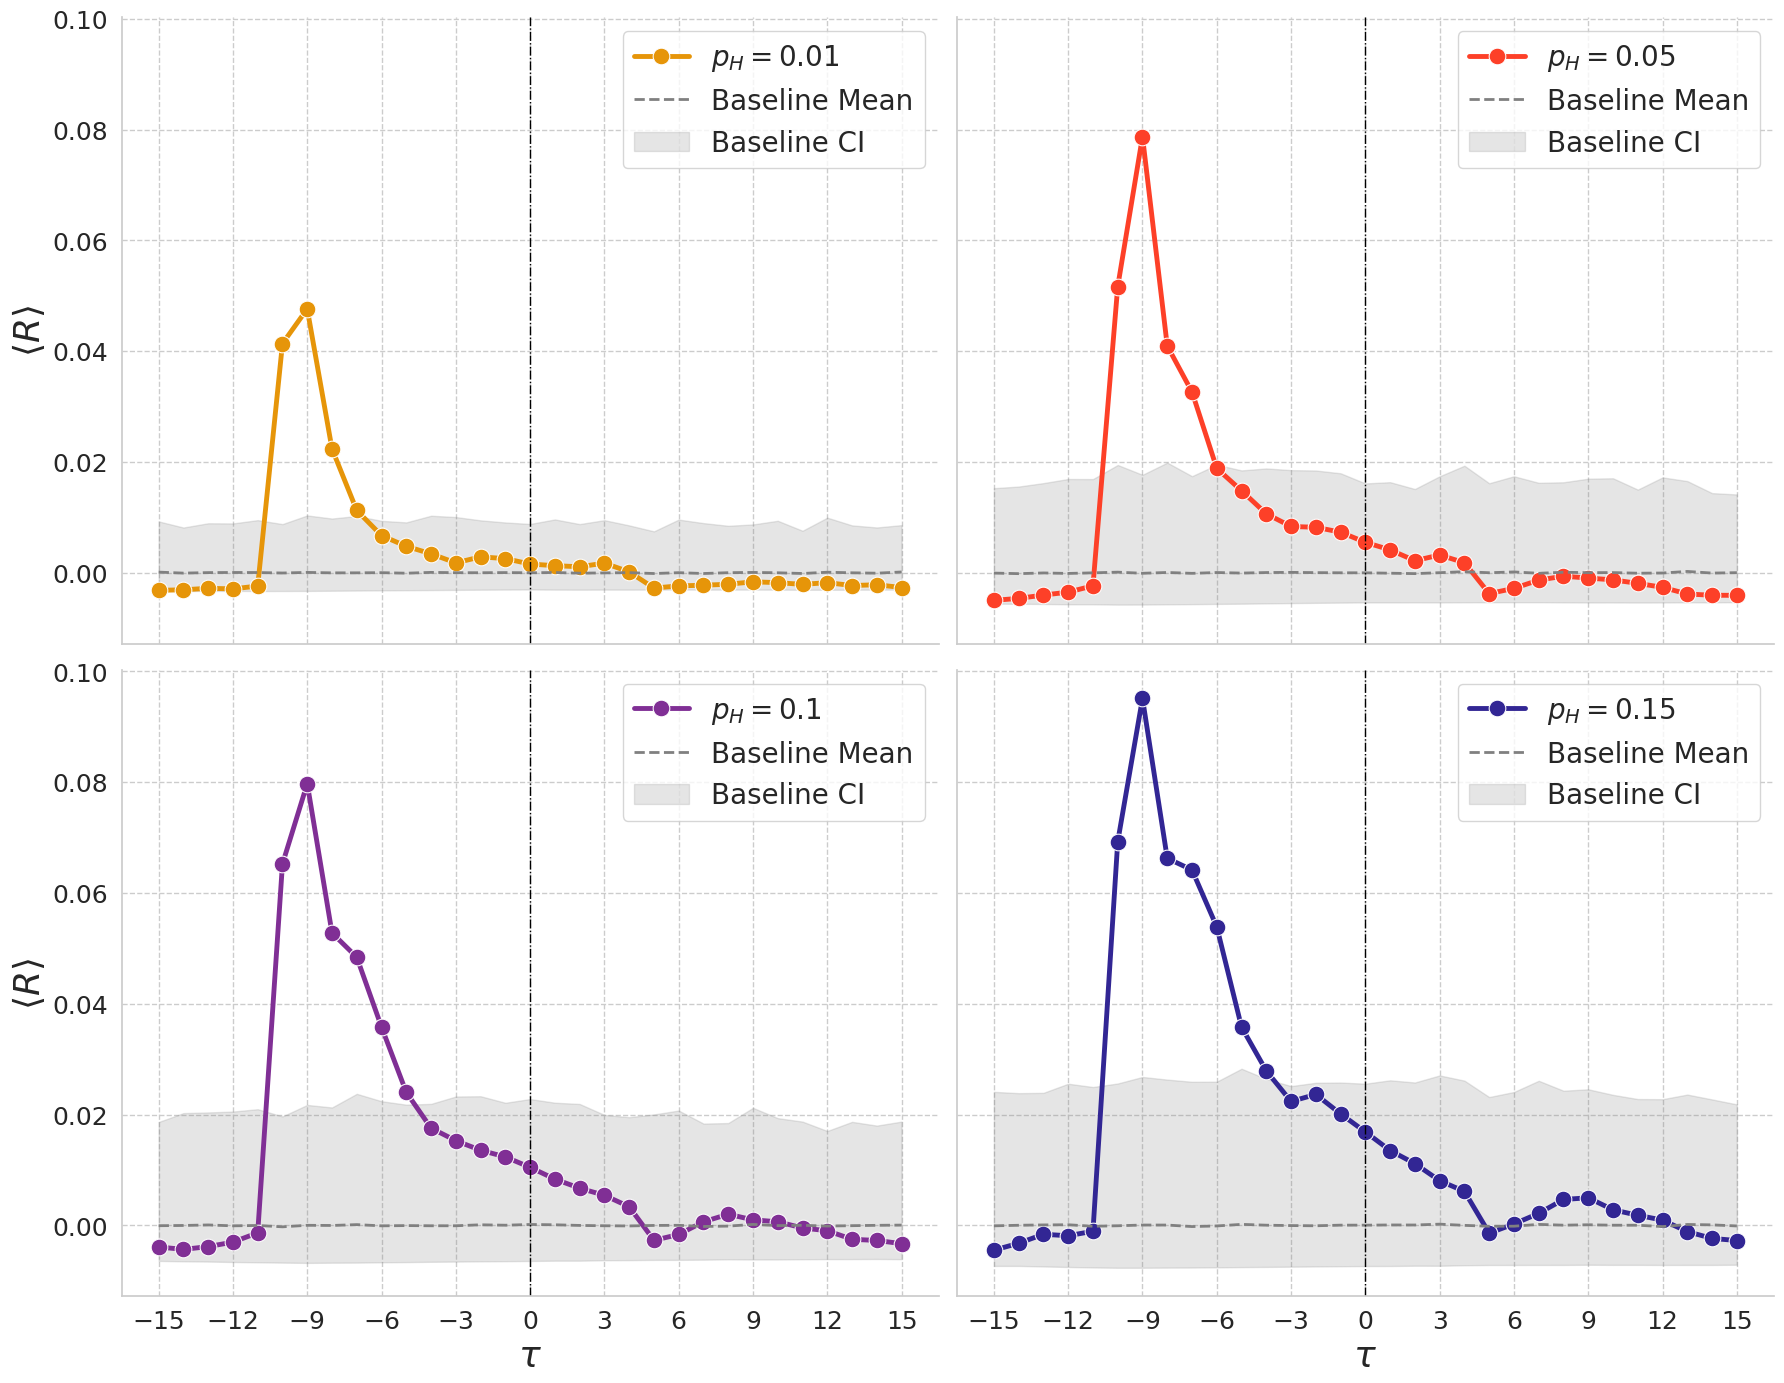

In [9]:

# Set the style
sns.set(style='whitegrid')
#palette = sns.color_palette("rocket_r", len(pg_values))
palette = sns.color_palette("CMRmap_r", len(pg_values) + 1)[1:]


# Plotting function for individual subplots with shared x and y axes
def plot_lag_correlations_with_shuffles_subplots(lags, correlations, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values):
    # Create a 2x2 subplot grid with shared x and y axes
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharex='col', sharey=True)
    axes = axes.flatten()  # Flatten to iterate over each axis easily
    
    for i, pg in enumerate(pg_values):
        ax = axes[i]
        color = palette[i]
        
        # Plot actual correlation line
        sns.lineplot(x=lags, y=correlations[i], marker='o', label=f'$p_H={pg}$', color=color, linewidth=3.5, markersize=12, ax=ax)
        
        # Plot mean shuffled correlation line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=2)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

        # Customize each subplot's labels and title
        if i % 2 == 0:
            ax.set_ylabel(r'$\langle R \rangle$', fontsize=26)  # Set y label only for the left column
        if i >= 2:
            ax.set_xlabel(r'$\tau$', fontsize=26)  # Set x label only for the bottom row

        # Set custom ticks for the x-axis at every 2 units
        ax.set_xticks(np.arange(-max_lag, max_lag+1, 3))
        ax.tick_params(axis='y', which='major', labelsize=18)
        ax.tick_params(axis='x', which='major', labelsize=18)

        #vertical line at 0
        ax.axvline(0, color='black', linestyle='-.', linewidth=1)

        # Show legend
        ax.legend(fontsize=20, loc='upper right')

    # Set common y-axis and grid for all subplots
    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=1)
        #despine
        sns.despine(ax=ax)
        

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "ALL_cross_correlation_lags.pdf"), bbox_inches='tight')

    plt.show()

# Plotting with the calculated data in subplots
plot_lag_correlations_with_shuffles_subplots(lags, all_correlations, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values)


In [ ]:
stop

# Only One

In [3]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed




starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


# Fixed parameters
h = 20
delta = 15
max_lag = delta
num_rep = 150

# Values of p_g to iterate over
pg_values = [0.1]

# Folder containing the data files (replace with actual path)
intermediate_folder = intermediate_dir  # Update this path to your actual data folder





def process_file_pair(chi_hat_file, gamma_file, h, max_lag):
    # Initialize empty results
    result = None
    shuffled_result = None
    lags = None  # Initialize lags variable
    
    if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
        chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
        gamma_df = pd.read_csv(gamma_file, index_col=0)

        # Fill initial NaNs with zeros
        chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
        gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

        all_lag_correlations = []
        all_lag_shuffled_means = []
        all_lag_shuffled_lowers = []
        all_lag_shuffled_uppers = []

        for column in chi_hat_df.columns:
            if column in gamma_df.columns:
                chi_hat_series = chi_hat_df[column].values
                gamma_series = gamma_df[column].values

                # Create binary series
                chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)

                # Calculate cross-correlation for the binary series
                lags, correlation_values = calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag)
                all_lag_correlations.append(correlation_values)

                # Calculate cross-correlation for shuffled binary series
                mean_shuffled_corr, lower_bound, upper_bound = calculate_shuffled_correlations_bidirectional(
                    gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag)

                # Append shuffled correlation statistics
                all_lag_shuffled_means.append(mean_shuffled_corr)
                all_lag_shuffled_lowers.append(lower_bound)
                all_lag_shuffled_uppers.append(upper_bound)

        # Average correlation values across all columns for this file pair
        if all_lag_correlations:
            avg_correlation = np.mean(all_lag_correlations, axis=0)
            result = avg_correlation

        # Average shuffled statistics across all columns for this file pair
        if all_lag_shuffled_means:
            avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
            avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
            avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

            shuffled_result = (avg_shuffled_mean, avg_shuffled_lower, avg_shuffled_upper)
    
    return lags, result, shuffled_result  # Return lags along with results



# Parallel processing of each p_g value
all_correlations = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []
lags_list = []  # List to store lags for each pg_value

# Iterate over each p_g value
for p_g in pg_values:
    all_lag_correlations = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    # File paths for the fixed parameters and repetitions
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]

    # Prepare for parallel processing
    with ProcessPoolExecutor() as executor:
        # Partial function to include fixed parameters
        process_func = partial(process_file_pair, h=h, max_lag=max_lag)
        # Submit all jobs to the executor
        futures = [executor.submit(process_func, chi_hat_file, gamma_file) for chi_hat_file, gamma_file in zip(chi_hat_files, gamma_files)]
        
        # Collect results as they complete
        for future in tqdm(as_completed(futures), total=len(futures)):
            lags, result, shuffled_result = future.result()
            
            if result is not None:
                all_lag_correlations.append(result)
            
            if shuffled_result is not None:
                all_lag_shuffled_means.append(shuffled_result[0])
                all_lag_shuffled_lowers.append(shuffled_result[1])
                all_lag_shuffled_uppers.append(shuffled_result[2])
    
    # Save the lags for this p_g value (should be the same for all repetitions)
    if lags is not None:
        lags_list.append(lags)

    # Average correlation values across all repetitions and columns for this p_g
    if all_lag_correlations:
        avg_correlation = np.mean(all_lag_correlations, axis=0)
        all_correlations.append(avg_correlation)

    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)

# Check if lags are consistent across all p_g values
if len(set(map(tuple, lags_list))) == 1:
    lags = lags_list[0]  # Use the first one as the final lags
else:
    print("Warning: Lags are not consistent across different p_g values.")

100%|██████████| 150/150 [00:00<00:00, 2883.22it/s]

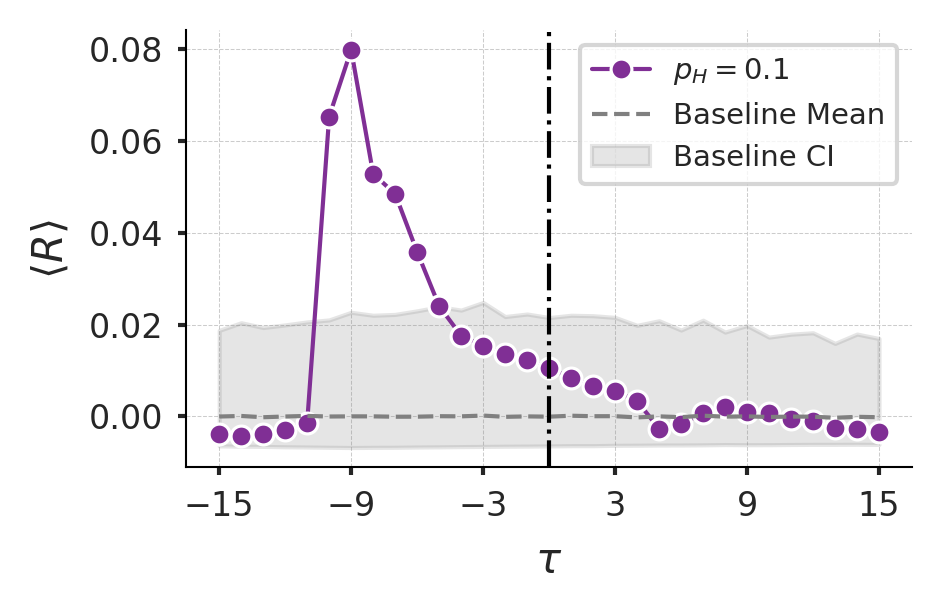

In [12]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set the style
sns.set(style='whitegrid')
palette = sns.color_palette("CMRmap_r", 4 + 1)[1:]

# Plotting function for individual subplots with shared x and y axes
def plot_lag_correlations_with_shuffles_subplots(lags, correlations, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values):
    # Create a figure with a single plot (you mentioned subplots but there's only one axis)
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=300)
    
    for i, pg in enumerate(pg_values):
        color = palette[2]
        
        # Plot actual correlation line
        sns.lineplot(x=lags, y=correlations[i], marker='o', label=f'$p_H={pg}$', color=color, linewidth=1, markersize=5, ax=ax)
        
        # Plot mean shuffled correlation line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=1)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

    # Set axis labels with appropriate font size
    ax.set_ylabel(r'$\langle R \rangle$', fontsize=10)
    ax.set_xlabel(r'$\tau$', fontsize=10)

    # Set custom ticks for the x-axis at every 3 units, and adjust tick label size
    ax.set_xticks(np.arange(-max_lag, max_lag+1, 6))
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=1)

    ax.axvline(0, color='black', linestyle='-.', linewidth=1)

    # Add grid with specific styling
    ax.grid(True, linestyle='--', linewidth=0.25)

    # Remove top and right spines, and adjust left and bottom spine thickness
    sns.despine(ax=ax)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


    # Show legend with a smaller font size
    ax.legend(fontsize=7, loc='upper right')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save the figure (make sure `out_plot_directory` and `num_agents` are defined)
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "cross_correlation_lags.pdf"), bbox_inches='tight')

    # Display the plot
    plt.show()

# Plotting with the calculated data in subplots
plot_lag_correlations_with_shuffles_subplots(lags, all_correlations, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values)


In [ ]:
stop

# ONLY ONE AGAINST RANDOM

In [5]:
#do the only one but with the random data in batch_results

from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed




mode = "random"

starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{mode}/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


# Fixed parameters
h = 20
delta = 15
max_lag = delta
num_rep = 150

# Values of p_g to iterate over
pg_values = [0.01]

# Folder containing the data files (replace with actual path)
intermediate_folder = intermediate_dir  # Update this path to your actual data folder





def process_file_pair(chi_hat_file, gamma_file, h, max_lag):
    # Initialize empty results
    result = None
    shuffled_result = None
    lags = None  # Initialize lags variable
    
    if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
        chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
        gamma_df = pd.read_csv(gamma_file, index_col=0)

        # Fill initial NaNs with zeros
        chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
        gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

        all_lag_correlations = []
        all_lag_shuffled_means = []
        all_lag_shuffled_lowers = []
        all_lag_shuffled_uppers = []

        for column in chi_hat_df.columns:
            if column in gamma_df.columns:
                chi_hat_series = chi_hat_df[column].values
                gamma_series = gamma_df[column].values

                # Create binary series
                chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)

                # Calculate cross-correlation for the binary series
                lags, correlation_values = calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag)
                all_lag_correlations.append(correlation_values)

                # Calculate cross-correlation for shuffled binary series
                mean_shuffled_corr, lower_bound, upper_bound = calculate_shuffled_correlations_bidirectional(
                    gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag)

                # Append shuffled correlation statistics
                all_lag_shuffled_means.append(mean_shuffled_corr)
                all_lag_shuffled_lowers.append(lower_bound)
                all_lag_shuffled_uppers.append(upper_bound)

        # Average correlation values across all columns for this file pair
        if all_lag_correlations:
            avg_correlation = np.mean(all_lag_correlations, axis=0)
            result = avg_correlation

        # Average shuffled statistics across all columns for this file pair
        if all_lag_shuffled_means:
            avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
            avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
            avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

            shuffled_result = (avg_shuffled_mean, avg_shuffled_lower, avg_shuffled_upper)
    
    return lags, result, shuffled_result  # Return lags along with results



# Parallel processing of each p_g value
all_correlations = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []
lags_list = []  # List to store lags for each pg_value

# Iterate over each p_g value
for p_g in pg_values:
    all_lag_correlations = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    # File paths for the fixed parameters and repetitions
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]

    # Prepare for parallel processing
    with ProcessPoolExecutor() as executor:
        # Partial function to include fixed parameters
        process_func = partial(process_file_pair, h=h, max_lag=max_lag)
        # Submit all jobs to the executor
        futures = [executor.submit(process_func, chi_hat_file, gamma_file) for chi_hat_file, gamma_file in zip(chi_hat_files, gamma_files)]
        
        # Collect results as they complete
        for future in tqdm(as_completed(futures), total=len(futures)):
            lags, result, shuffled_result = future.result()
            
            if result is not None:
                all_lag_correlations.append(result)
            
            if shuffled_result is not None:
                all_lag_shuffled_means.append(shuffled_result[0])
                all_lag_shuffled_lowers.append(shuffled_result[1])
                all_lag_shuffled_uppers.append(shuffled_result[2])
    
    # Save the lags for this p_g value (should be the same for all repetitions)
    if lags is not None:
        lags_list.append(lags)

    # Average correlation values across all repetitions and columns for this p_g
    if all_lag_correlations:
        avg_correlation = np.mean(all_lag_correlations, axis=0)
        all_correlations.append(avg_correlation)

    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)

# Check if lags are consistent across all p_g values
if len(set(map(tuple, lags_list))) == 1:
    lags = lags_list[0]  # Use the first one as the final lags
else:
    print("Warning: Lags are not consistent across different p_g values.")

100%|██████████| 150/150 [00:28<00:00,  5.36it/s]


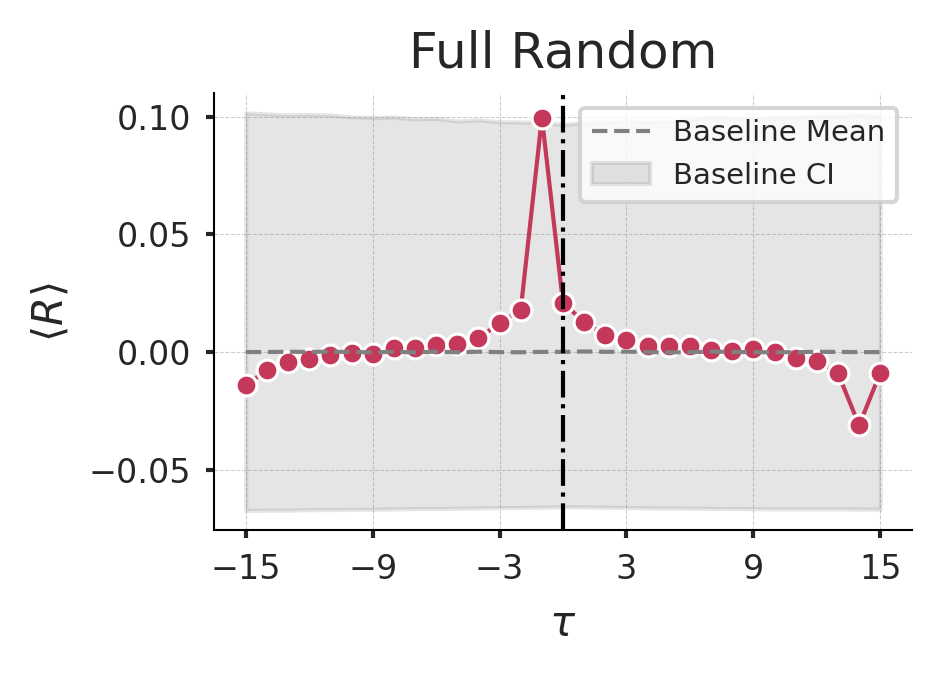

In [6]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set the style
sns.set(style='whitegrid')
palette = sns.color_palette("CMRmap_r", 20)

# Plotting function for individual subplots with shared x and y axes
def plot_lag_correlations_with_shuffles_subplots(lags, correlations, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values):
    # Create a figure with a single plot (you mentioned subplots but there's only one axis)
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=300)
    
    for i, pg in enumerate(pg_values):
        color = palette[11]
        
        # Plot actual correlation line
        sns.lineplot(x=lags, y=correlations[i], marker='o', label=f'', color=color, linewidth=1, markersize=5, ax=ax)
        
        # Plot mean shuffled correlation line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=1)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

    # Set axis labels with appropriate font size
    ax.set_ylabel(r'$\langle R \rangle$', fontsize=10)
    ax.set_xlabel(r'$\tau$', fontsize=10)

    # Set custom ticks for the x-axis at every 3 units, and adjust tick label size
    ax.set_xticks(np.arange(-max_lag, max_lag+1, 6))
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=1)

    ax.axvline(0, color='black', linestyle='-.', linewidth=1)

    # Add grid with specific styling
    ax.grid(True, linestyle='--', linewidth=0.25)

    # Remove top and right spines, and adjust left and bottom spine thickness
    sns.despine(ax=ax)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


    # Show legend with a smaller font size
    ax.legend(fontsize=7, loc='upper right')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    plt.title(f"Full Random")
    # Save the figure (make sure `out_plot_directory` and `num_agents` are defined)
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "SUPPL_random_cross_correlation_lags.pdf"), bbox_inches='tight')

    # Display the plot
    plt.show()

# Plotting with the calculated data in subplots
plot_lag_correlations_with_shuffles_subplots(lags, all_correlations, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values)


# ONLY ONE AGAINST RANDOMDEST

In [7]:
#do the only one but with the random data in batch_results

from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed




mode = "randomdest"

starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{mode}/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


# Fixed parameters
h = 20
delta = 15
max_lag = delta
num_rep = 150

# Values of p_g to iterate over
pg_values = [0.1]

# Folder containing the data files (replace with actual path)
intermediate_folder = intermediate_dir  # Update this path to your actual data folder





def process_file_pair(chi_hat_file, gamma_file, h, max_lag):
    # Initialize empty results
    result = None
    shuffled_result = None
    lags = None  # Initialize lags variable
    
    if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
        chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
        gamma_df = pd.read_csv(gamma_file, index_col=0)

        # Fill initial NaNs with zeros
        chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
        gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

        all_lag_correlations = []
        all_lag_shuffled_means = []
        all_lag_shuffled_lowers = []
        all_lag_shuffled_uppers = []

        for column in chi_hat_df.columns:
            if column in gamma_df.columns:
                chi_hat_series = chi_hat_df[column].values
                gamma_series = gamma_df[column].values

                # Create binary series
                chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)

                # Calculate cross-correlation for the binary series
                lags, correlation_values = calculate_cross_correlation(chi_hat_bin, gamma_bin, max_lag)
                all_lag_correlations.append(correlation_values)

                # Calculate cross-correlation for shuffled binary series
                mean_shuffled_corr, lower_bound, upper_bound = calculate_shuffled_correlations_bidirectional(
                    gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag)

                # Append shuffled correlation statistics
                all_lag_shuffled_means.append(mean_shuffled_corr)
                all_lag_shuffled_lowers.append(lower_bound)
                all_lag_shuffled_uppers.append(upper_bound)

        # Average correlation values across all columns for this file pair
        if all_lag_correlations:
            avg_correlation = np.mean(all_lag_correlations, axis=0)
            result = avg_correlation

        # Average shuffled statistics across all columns for this file pair
        if all_lag_shuffled_means:
            avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
            avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
            avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

            shuffled_result = (avg_shuffled_mean, avg_shuffled_lower, avg_shuffled_upper)
    
    return lags, result, shuffled_result  # Return lags along with results



# Parallel processing of each p_g value
all_correlations = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []
lags_list = []  # List to store lags for each pg_value

# Iterate over each p_g value
for p_g in pg_values:
    all_lag_correlations = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    # File paths for the fixed parameters and repetitions
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]

    # Prepare for parallel processing
    with ProcessPoolExecutor() as executor:
        # Partial function to include fixed parameters
        process_func = partial(process_file_pair, h=h, max_lag=max_lag)
        # Submit all jobs to the executor
        futures = [executor.submit(process_func, chi_hat_file, gamma_file) for chi_hat_file, gamma_file in zip(chi_hat_files, gamma_files)]
        
        # Collect results as they complete
        for future in tqdm(as_completed(futures), total=len(futures)):
            lags, result, shuffled_result = future.result()
            
            if result is not None:
                all_lag_correlations.append(result)
            
            if shuffled_result is not None:
                all_lag_shuffled_means.append(shuffled_result[0])
                all_lag_shuffled_lowers.append(shuffled_result[1])
                all_lag_shuffled_uppers.append(shuffled_result[2])
    
    # Save the lags for this p_g value (should be the same for all repetitions)
    if lags is not None:
        lags_list.append(lags)

    # Average correlation values across all repetitions and columns for this p_g
    if all_lag_correlations:
        avg_correlation = np.mean(all_lag_correlations, axis=0)
        all_correlations.append(avg_correlation)

    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)

# Check if lags are consistent across all p_g values
if len(set(map(tuple, lags_list))) == 1:
    lags = lags_list[0]  # Use the first one as the final lags
else:
    print("Warning: Lags are not consistent across different p_g values.")

100%|██████████| 150/150 [00:28<00:00,  5.35it/s]


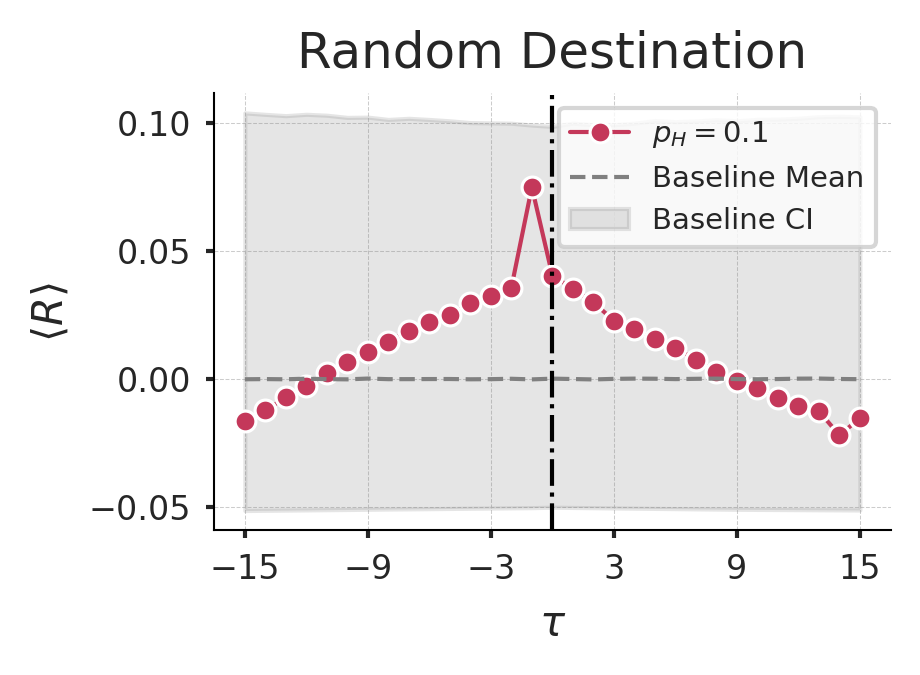

In [9]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set the style
sns.set(style='whitegrid')
palette = sns.color_palette("CMRmap_r", 20)

# Plotting function for individual subplots with shared x and y axes
def plot_lag_correlations_with_shuffles_subplots(lags, correlations, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values):
    # Create a figure with a single plot (you mentioned subplots but there's only one axis)
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=300)
    
    for i, pg in enumerate(pg_values):
        color = palette[11]
        
        # Plot actual correlation line
        sns.lineplot(x=lags, y=correlations[i], marker='o', label=f'$p_H={pg}$', color=color, linewidth=1, markersize=5, ax=ax)
        
        # Plot mean shuffled correlation line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=1)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

    # Set axis labels with appropriate font size
    ax.set_ylabel(r'$\langle R \rangle$', fontsize=10)
    ax.set_xlabel(r'$\tau$', fontsize=10)

    # Set custom ticks for the x-axis at every 3 units, and adjust tick label size
    ax.set_xticks(np.arange(-max_lag, max_lag+1, 6))
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=1)

    ax.axvline(0, color='black', linestyle='-.', linewidth=1)

    # Add grid with specific styling
    ax.grid(True, linestyle='--', linewidth=0.25)

    # Remove top and right spines, and adjust left and bottom spine thickness
    sns.despine(ax=ax)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


    # Show legend with a smaller font size
    ax.legend(fontsize=7, loc='upper right')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.title("Random Destination")

    # Save the figure (make sure `out_plot_directory` and `num_agents` are defined)
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "SUPPL_randomdest_cross_correlation_lags.pdf"), bbox_inches='tight')


    # Display the plot
    plt.show()

# Plotting with the calculated data in subplots
plot_lag_correlations_with_shuffles_subplots(lags, all_correlations, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values)


In [15]:
stop

NameError: name 'stop' is not defined

In [11]:
from sklearn.metrics import mutual_info_score


def calculate_mutual_information(series1, series2, n_bins=2):
    """
    Calculate the mutual information between two binary series.
    """
    # Ensure inputs are arrays
    series1 = np.asarray(series1)
    series2 = np.asarray(series2)
    
    # Binning the data (if not binary, to create discrete values)
    c_series1 = np.floor(series1 * n_bins).astype(int)
    c_series2 = np.floor(series2 * n_bins).astype(int)

    # Calculate mutual information
    return mutual_info_score(c_series1, c_series2)


def calculate_mutual_information_lags(chi_hat_bin, gamma_bin, max_lag=10, n_bins=2):
    mutual_info_values = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            segment1 = chi_hat_bin[-lag:]
            segment2 = gamma_bin[:lag]
        elif lag > 0:
            segment1 = chi_hat_bin[:-lag]
            segment2 = gamma_bin[lag:]
        else:
            segment1 = chi_hat_bin
            segment2 = gamma_bin

        # Check for meaningful MI calculation
        if np.any(segment1) and np.any(segment2):
            mi = calculate_mutual_information(segment1, segment2, n_bins)
        else:
            mi = 0  # No meaningful MI if segments are flat or have no overlap

        mutual_info_values.append(mi)
    
    return lags, mutual_info_values


def calculate_shuffled_mutual_information_bidirectional(gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=10, n_bins=2):
    shuffled_mutual_info = []

    # Precompute all shuffled versions of chi_hat_bin and gamma_bin
    shuffled_chi_hat_bins = [np.random.permutation(chi_hat_bin) for _ in range(num_shuffles)]
    shuffled_gamma_bins = [np.random.permutation(gamma_bin) for _ in range(num_shuffles)]

    for shuffle_idx in range(num_shuffles):
        # For each shuffle, we will calculate the mutual information using the pre-defined function
        # Negative lags: Shuffle chi_hat_bin, keep gamma_bin fixed
        _, mi_neg = calculate_mutual_information_lags(shuffled_chi_hat_bins[shuffle_idx], gamma_bin, max_lag, n_bins)
        
        # Positive lags: Shuffle gamma_bin, keep chi_hat_bin fixed
        _, mi_pos = calculate_mutual_information_lags(chi_hat_bin, shuffled_gamma_bins[shuffle_idx], max_lag, n_bins)
        
        # Combine mutual information into a single array
        combined_mi = list(mi_neg[:max_lag + 1]) + list(mi_pos[max_lag + 1:])
        shuffled_mutual_info.append(combined_mi)
    
    # Convert to numpy array for easier percentile calculations
    shuffled_mutual_info = np.array(shuffled_mutual_info)
    
    # Calculate mean, 5th, and 95th percentiles
    mean_shuffled_mi = np.mean(shuffled_mutual_info, axis=0)
    lower_bound = np.percentile(shuffled_mutual_info, 5, axis=0)
    upper_bound = np.percentile(shuffled_mutual_info, 95, axis=0)
    
    return mean_shuffled_mi, lower_bound, upper_bound


In [14]:

starting_deployment = "centre_segr"
num_agents = 2**12

directory = f"out/batch_results/{starting_deployment}/{num_agents}agents"
intermediate_dir = os.path.join(directory, "intermediate")
exp_directory = os.path.join(directory, "exps")

out_plot_directory = os.path.join("out/plots", starting_deployment)
os.makedirs(out_plot_directory, exist_ok=True)

out_plot_directory


# Fixed parameters
h = 20
delta = 15
max_lag = delta
num_rep = 150

# Values of p_g to iterate over
pg_values = [0.01, 0.05, 0.1, 0.15]

# Folder containing the data files (replace with actual path)
intermediate_folder = intermediate_dir  # Update this path to your actual data folder








# Store mutual information values for all p_g values
all_mutual_infos = []
all_shuffled_means = []
all_shuffled_lowers = []
all_shuffled_uppers = []
lags_list = []  # To store lags across repetitions

def process_files(chi_hat_file, gamma_file, h, max_lag):
    """Process a single pair of chi_hat and gamma files and return MI results along with lags."""
    if os.path.exists(chi_hat_file) and os.path.exists(gamma_file):
        chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
        gamma_df = pd.read_csv(gamma_file, index_col=0)

        # Fill initial NaNs with zeros
        chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
        gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

        all_lag_mis = []
        all_lag_shuffled_means = []
        all_lag_shuffled_lowers = []
        all_lag_shuffled_uppers = []
        lags = None  # Initialize lags to None

        for column in chi_hat_df.columns:
            if column in gamma_df.columns:
                chi_hat_series = chi_hat_df[column].values
                gamma_series = gamma_df[column].values

                # Create binary series
                chi_hat_bin = create_chi_hat_bin(chi_hat_series)
                gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)

                # Calculate mutual information for the binary series
                lags, mutual_info_values = calculate_mutual_information_lags(chi_hat_bin, gamma_bin, max_lag)
                all_lag_mis.append(mutual_info_values)

                # Calculate mutual information for shuffled binary series
                mean_shuffled_mi, lower_bound, upper_bound = calculate_shuffled_mutual_information_bidirectional(
                    gamma_bin, chi_hat_bin, num_shuffles=50, max_lag=max_lag
                )

                # Append shuffled mutual information statistics
                all_lag_shuffled_means.append(mean_shuffled_mi)
                all_lag_shuffled_lowers.append(lower_bound)
                all_lag_shuffled_uppers.append(upper_bound)

        return lags, all_lag_mis, all_lag_shuffled_means, all_lag_shuffled_lowers, all_lag_shuffled_uppers
    else:
        return None, [], [], [], []



# Iterate over each p_g value
for p_g in pg_values:
    chi_hat_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv" for rep in range(num_rep)]
    gamma_files = [f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv" for rep in range(num_rep)]

    all_lag_mis = []
    all_lag_shuffled_means = []
    all_lag_shuffled_lowers = []
    all_lag_shuffled_uppers = []

    with ProcessPoolExecutor() as executor:
        # Submit all file pairs to the executor
        futures = [executor.submit(process_files, chi_hat_file, gamma_file, h, max_lag) for chi_hat_file, gamma_file in zip(chi_hat_files, gamma_files)]

        for future in tqdm(as_completed(futures), total=len(futures)):
            lags, lag_mis, lag_shuffled_means, lag_shuffled_lowers, lag_shuffled_uppers = future.result()

            if lags is not None:
                lags_list.append(lags)  # Collect lags if not None
            all_lag_mis.extend(lag_mis)
            all_lag_shuffled_means.extend(lag_shuffled_means)
            all_lag_shuffled_lowers.extend(lag_shuffled_lowers)
            all_lag_shuffled_uppers.extend(lag_shuffled_uppers)

    # Save the lags for this p_g value (should be the same for all repetitions)
    if lags is not None:
        lags_list.append(lags)

    # Average mutual information values across all repetitions and columns for this p_g
    if all_lag_mis:
        avg_mi = np.mean(all_lag_mis, axis=0)
        all_mutual_infos.append(avg_mi)

    # Average shuffled statistics across all repetitions for this p_g
    if all_lag_shuffled_means:
        avg_shuffled_mean = np.mean(all_lag_shuffled_means, axis=0)
        avg_shuffled_lower = np.mean(all_lag_shuffled_lowers, axis=0)
        avg_shuffled_upper = np.mean(all_lag_shuffled_uppers, axis=0)

        all_shuffled_means.append(avg_shuffled_mean)
        all_shuffled_lowers.append(avg_shuffled_lower)
        all_shuffled_uppers.append(avg_shuffled_upper)

# Check if lags are consistent across all p_g values
if len(set(map(tuple, lags_list))) == 1:
    lags = lags_list[0]  # Use the first one as the final lags
else:
    print("Warning: Lags are not consistent across different p_g values.")


100%|██████████| 150/150 [03:11<00:00,  1.27s/it]


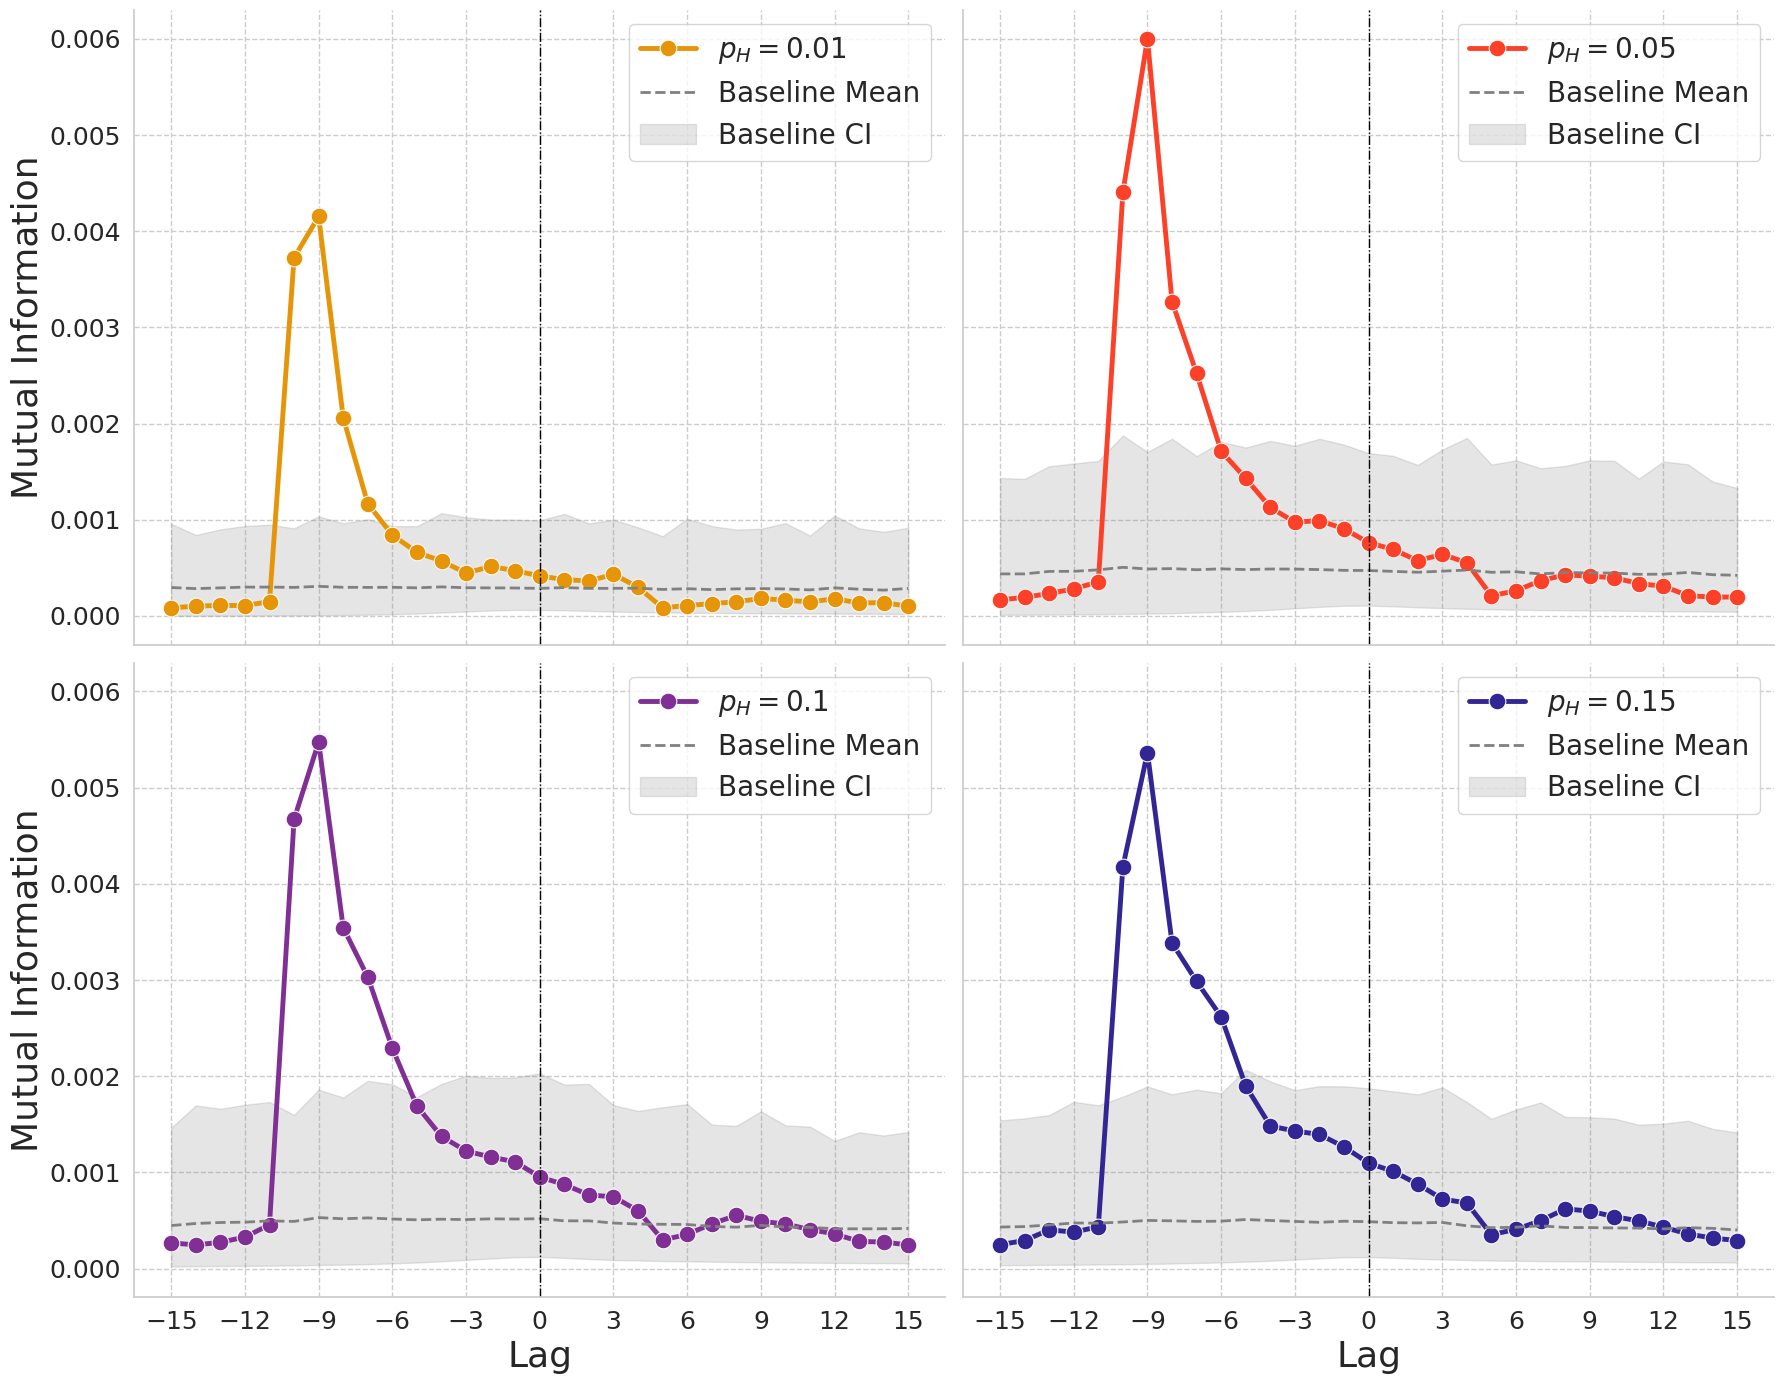

In [15]:
palette = sns.color_palette("CMRmap_r", len(pg_values) + 1)[1:]

def plot_lag_mutual_information_with_shuffles_subplots(lags, mutual_infos, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values):
    # Create a 2x2 subplot grid with shared x and y axes
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharex='col', sharey=True)
    axes = axes.flatten()  # Flatten to iterate over each axis easily
    
    for i, pg in enumerate(pg_values):
        ax = axes[i]
        color = palette[i]
        
        # Plot actual mutual information line
        sns.lineplot(x=lags, y=mutual_infos[i], marker='o', label=f'$p_H={pg}$', color=color, linewidth=3.5, markersize=12, ax=ax)
        
        # Plot mean shuffled mutual information line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=2)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

        # Customize each subplot's labels and title
        if i % 2 == 0:
            ax.set_ylabel('Mutual Information', fontsize=26)  # Set y label only for the left column
        if i >= 2:
            ax.set_xlabel('Lag', fontsize=26)  # Set x label only for the bottom row

        # Set custom ticks for the x-axis at every 2 units
        ax.set_xticks(np.arange(-max_lag, max_lag+1, 3))
        ax.tick_params(axis='y', which='major', labelsize=18)
        ax.tick_params(axis='x', which='major', labelsize=18)

        #vertical line at 0
        ax.axvline(0, color='black', linestyle='-.', linewidth=1)

        # Show legend
        ax.legend(fontsize=20, loc='upper right')

    # Set common y-axis and grid for all subplots
    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=1)
        # Remove top and right spines
        sns.despine(ax=ax)
        
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #save in the plotting dir, num_agents
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "ALL_mutual_information_lags.pdf"), bbox_inches='tight')
    plt.show()


    
# Plotting with the calculated data in subplots
plot_lag_mutual_information_with_shuffles_subplots(lags, all_mutual_infos, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values)


# Only one

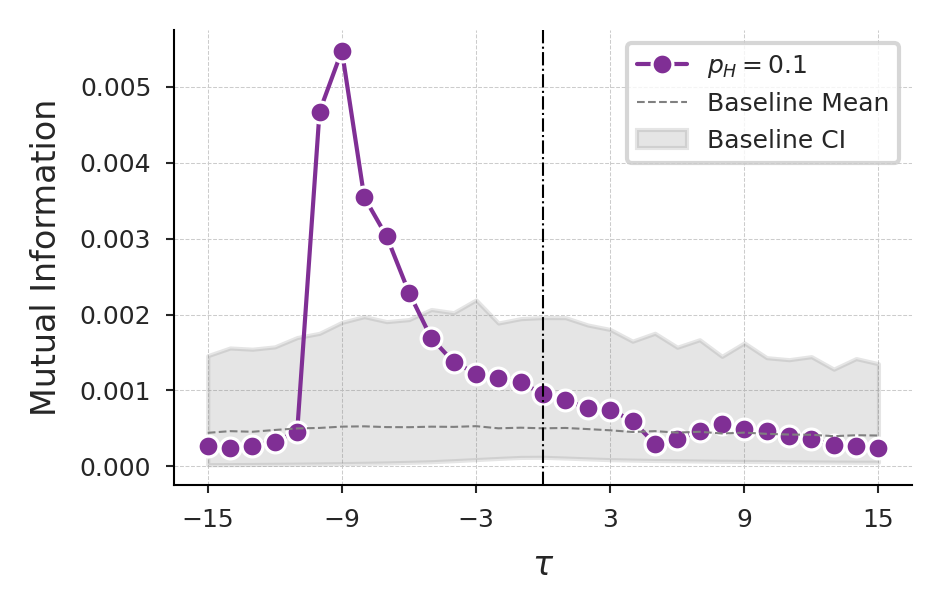

In [31]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set the style
sns.set(style='whitegrid')
palette = sns.color_palette("CMRmap_r", 4 + 1)[1:]


def plot_lag_mutual_information_with_shuffles(lags, mutual_infos, shuffled_means, shuffled_lowers, shuffled_uppers, pg_values, max_lag, out_plot_directory, num_agents):
    # Create a figure with a single plot
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=300)
    
    for i, pg in enumerate(pg_values):
        color = palette[2]
        
        # Plot actual mutual information line
        sns.lineplot(x=lags, y=mutual_infos[i], marker='o', label=f'$p_H={pg}$', color=color, linewidth=1, markersize=5, ax=ax)
        
        # Plot mean shuffled mutual information line
        ax.plot(lags, shuffled_means[i], label=f'Baseline Mean', color='gray', linestyle='--', linewidth=0.5)
        
        # Fill area between 5th and 95th percentile
        ax.fill_between(lags, shuffled_lowers[i], shuffled_uppers[i], color='gray', alpha=0.2, label='Baseline CI')

    # Set axis labels with appropriate font size
    ax.set_ylabel('Mutual Information', fontsize=8)
    ax.set_xlabel(r'$\tau$', fontsize=8)

    # Set custom ticks for the x-axis at every 6 units, and adjust tick label size
    ax.set_xticks(np.arange(-max_lag, max_lag+1, 6))
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=6, length=2, width=0.5)

    ax.axvline(0, color='black', linestyle='-.', linewidth=0.5)

    # Add grid with specific styling
    ax.grid(True, linestyle='--', linewidth=0.25)

    # Remove top and right spines, and adjust left and bottom spine thickness
    sns.despine(ax=ax)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Show legend with a smaller font size
    ax.legend(fontsize=6, loc='upper right')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "mutual_information_lags.pdf"), bbox_inches='tight')

    # Display the plot
    plt.show()

# Usage example (commented out):
# plot_lag_mutual_information_with_shuffles(lags, all_mutual_infos, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values, max_lag, out_plot_directory, num_agents)



plot_lag_mutual_information_with_shuffles(lags, all_mutual_infos, all_shuffled_means, all_shuffled_lowers, all_shuffled_uppers, pg_values, max_lag, out_plot_directory, num_agents)



In [4]:


def plot_gamma_chi_hat_series(chi_hat_series, gamma_series):
    # Create a figure with a single plot
    fig, ax = plt.subplots(figsize=(3.3, 2.2), dpi=400)
    
    # Plot chi_hat_series
    ax.plot(chi_hat_series, label=r"$\mathcal{G}_{bin}$", color='#2A2E34', 
            linewidth=1, marker='s', markersize=2.5, markeredgewidth=0.55)
    
    # Plot gamma_series
    ax.plot(gamma_series, label=r"$\mathcal{G}_{net}$", color='#eeba2c', 
            linewidth=1, marker='o', markersize=2.5, markeredgewidth=0.55)
    
    # Remove right and top spines
    sns.despine(ax=ax)
    
    # Set grid alpha
    ax.grid(linestyle="--", linewidth=0.25)
    
    # Set xticks and xtick labels
    ax.set_xticks(np.arange(0, len(chi_hat_series), 40))
    ax.set_xticklabels(np.arange(0, len(chi_hat_series), 40), fontsize=12)
    
    # Set yticks and ytick labels between 0 and 1 with steps of 0.2
    y_ticks = np.arange(0, 1.1, 0.2)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{ytick:.1f}" for ytick in y_ticks], fontsize=12)
    
    # Customize the spines
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    


    
    # Set tick parameters
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=0.6)

    
    # Add legend with smaller font
    leg = ax.legend(title='', fontsize=7, frameon=True)
    frame = leg.get_frame()
    frame.set_edgecolor('darkgrey')
    frame.set_linewidth(.5)
    
    # Set limits for x-axis and y-axis
    ax.set_ylim(-0.25, 1.1)
    
    # Set labels
    ax.set_xlabel(r"$t$", fontsize=10)
    ax.set_ylabel("")
    
    # Set layout for a smaller figure
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    



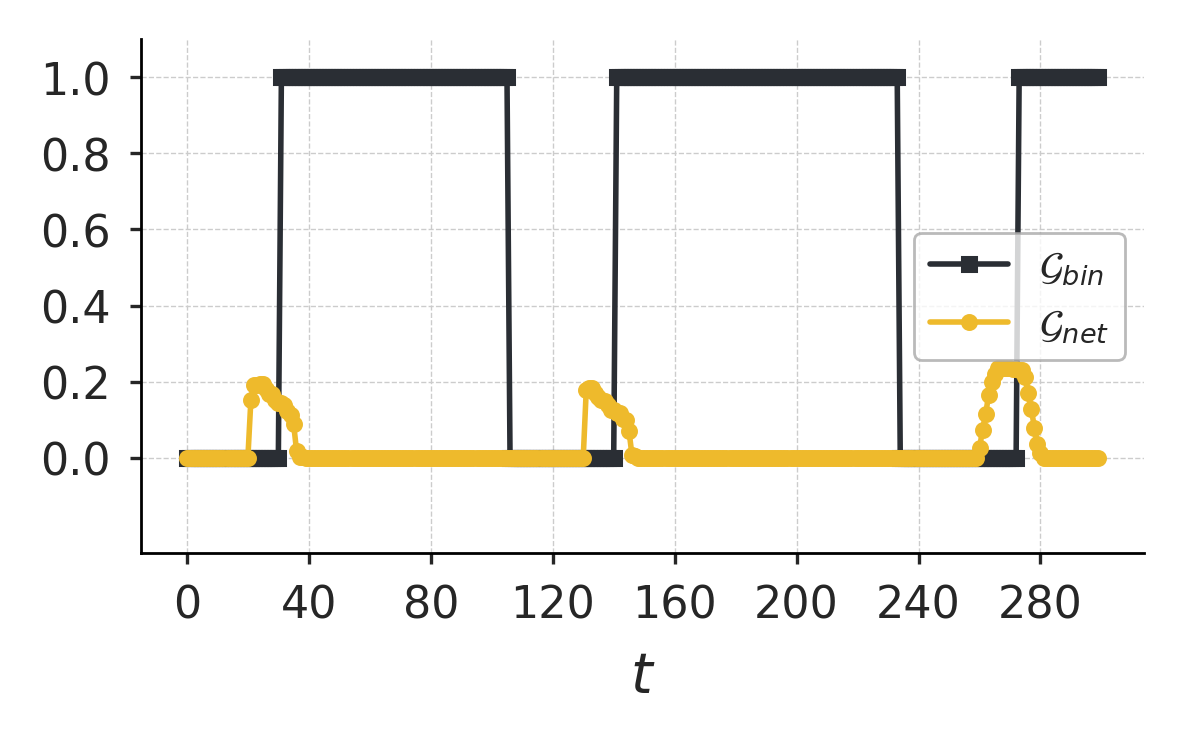

In [5]:
#fix the parameters and read a random chi_hat_series and gamma_series

p_g = 0.15
h = 20
rep = 0
delta = 15

intermediate_folder = intermediate_dir
chi_hat_file = f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_chi_hat.csv"
gamma_file = f"{intermediate_folder}/pg_{p_g}_h_{h}_rep_{rep}_delta_{delta}_results_net_avg_prod.csv"

chi_hat_df = pd.read_csv(chi_hat_file, index_col=0)
gamma_df = pd.read_csv(gamma_file, index_col=0)

# Fill initial NaNs with zeros
chi_hat_df = chi_hat_df.fillna({col: {i: 0 for i in range(h+1)} for col in chi_hat_df.columns})
gamma_df = gamma_df.fillna({col: {i: 0 for i in range(h+1)} for col in gamma_df.columns})

# Select a random column from the dataframes
#column = np.random.choice(chi_hat_df.columns)
column = '(5, 6)'


# Extract the chi_hat_series and gamma_series
chi_hat_series = chi_hat_df[column].values
gamma_series = gamma_df[column].values



#plot the series
plot_gamma_chi_hat_series(chi_hat_series, gamma_series)





In [6]:
#create a binary version of the series
chi_hat_bin = create_chi_hat_bin(chi_hat_series)
gamma_bin = create_gamma_bin(gamma_series, find_peaks_custom)




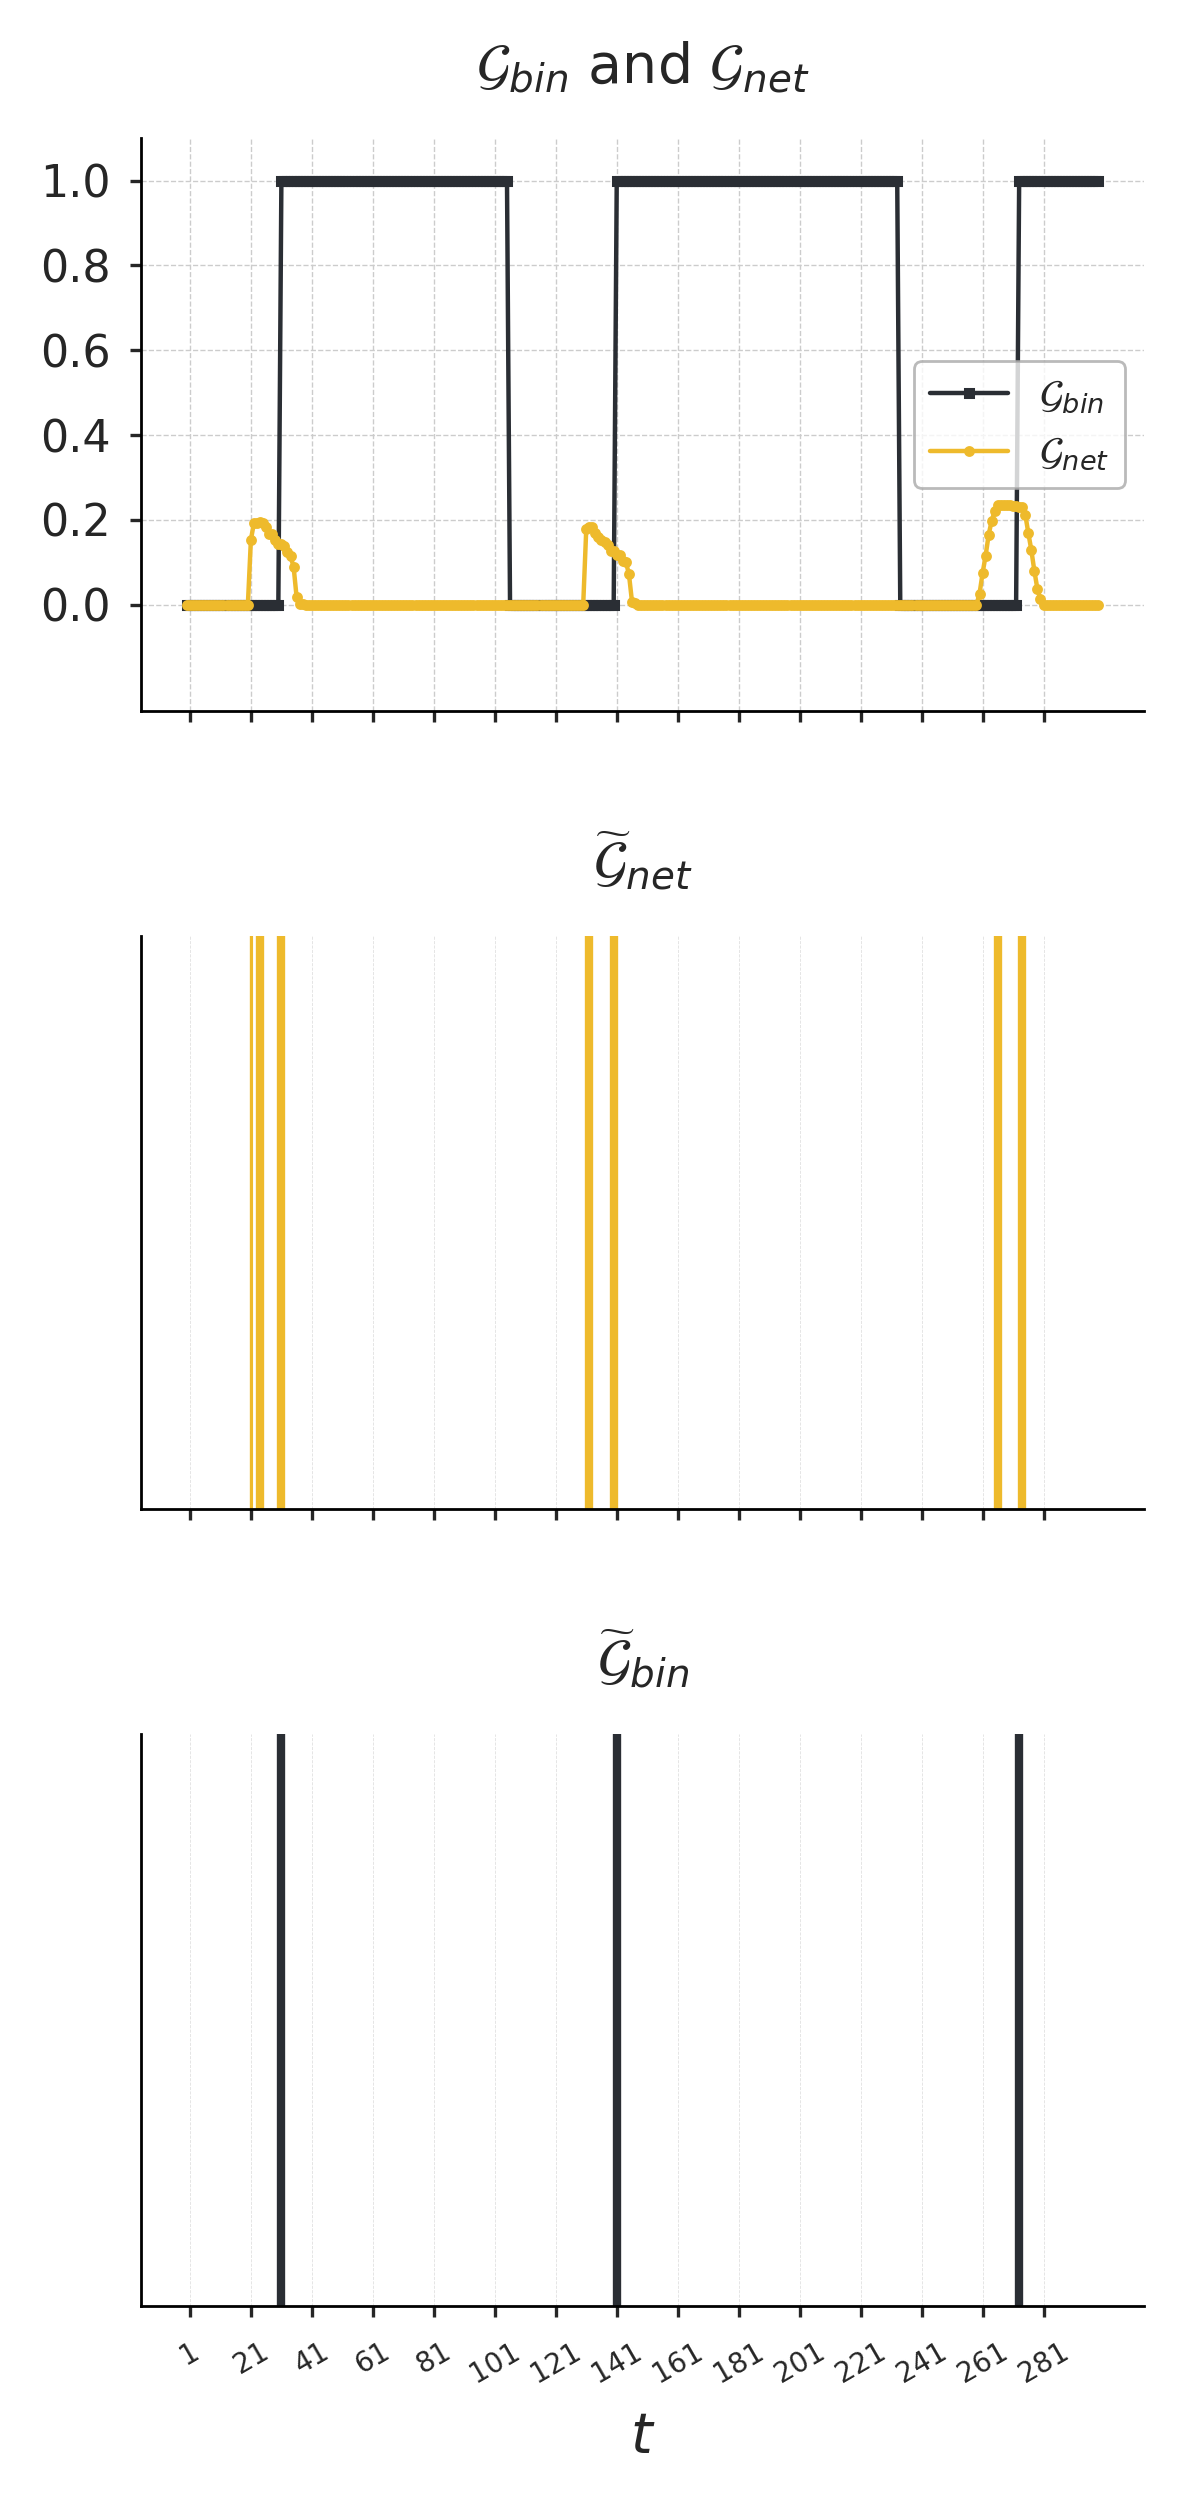

In [7]:
def plot_triple_lines_and_barcodes(chi_hat_series, gamma_series, chi_hat_bin, gamma_bin, fig_width=3.3, fig_height=6.6):
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(fig_width, fig_height), dpi=400, sharex=True)
    
    # Plot line graph (now first)
    ax1.plot(chi_hat_series, label=r"$\mathcal{G}_{bin}$", color='#2A2E34', 
             linewidth=0.8, marker='s', markersize=1.4, markeredgewidth=0.55)
    ax1.plot(gamma_series, label=r"$\mathcal{G}_{net}$", color='#eeba2c', 
             linewidth=0.8, marker='o', markersize=1.4, markeredgewidth=0.55)
    
    sns.despine(ax=ax1)
    ax1.grid(True, linestyle="--", linewidth=0.25)
    ax1.set_yticks(np.arange(0, 1.1, 0.2))
    ax1.set_yticklabels([f"{ytick:.1f}" for ytick in np.arange(0, 1.1, 0.2)], fontsize=12)
    ax1.spines['bottom'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(0.5)
    ax1.spines['left'].set_linewidth(0.5)
    ax1.tick_params(axis='both', bottom=True, left=True, labelsize=8, length=2, width=0.6)
    ax1.set_ylim(-0.25, 1.1)
    ax1.set_title(r"$\mathcal{G}_{bin}$ and $\mathcal{G}_{net}$", fontsize=10, pad=10)
    
    # Add legend to the line plot
    leg = ax1.legend(title='', fontsize=7, frameon=True)
    frame = leg.get_frame()
    frame.set_edgecolor('darkgrey')
    frame.set_linewidth(.5)
    


    
    # Plot barcodes
    for ax, series, name, color in zip([ax2, ax3], [gamma_bin, chi_hat_bin], 
                                       [r"$\widetilde{\mathcal{G}}_{net}$", r"$\widetilde{\mathcal{G}}_{bin}$"], 
                                       ['#eeba2c', '#2A2E34']):
        indices = np.where(series)[0]
        for idx in indices:
            # Plot white "edge" (thicker line behind)
            ax.axvline(x=idx, color='white', linewidth=2.5)
            # Plot colored line on top
            ax.axvline(x=idx, color=color, linewidth=1.5)
        
        sns.despine(ax=ax)
        ax.grid(True, linestyle="--", linewidth=0.15, alpha=0.6)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.tick_params(axis='x', bottom=True, labelsize=8, length=2, width=0.6)
        ax.set_ylim(-0.25, 1.1)
        ax.set_title(name, fontsize=10, pad=10)




    # Set x-axis ticks and labels for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks(np.arange(1, len(chi_hat_series), 20))
        ax.set_xticklabels(np.arange(1, len(chi_hat_series), 20), fontsize=5, rotation=30)
    
    # Set x-axis label for the bottom subplot
    ax3.set_xlabel(r"$t$", fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    return fig, (ax1, ax2, ax3)

# Usage example:
fig, (ax1, ax2, ax3) = plot_triple_lines_and_barcodes(chi_hat_series, gamma_series, chi_hat_bin, gamma_bin)
fig.savefig(os.path.join(f"{out_plot_directory}/{num_agents}", "barcode_comparison.pdf"), bbox_inches='tight')